In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contractions/contractions.csv
/kaggle/input/sarcasm/sarcasm_dataset.json


In [53]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, TFGPT2Model
from sklearn.metrics import classification_report

In [54]:
data = pd.read_json("../input/sarcasm/sarcasm_dataset.json", lines=True)
data

,is_sarcastic,headline
0,1,It feels like just a few days ago it was the l...
1,1,"I love my mom . No matter what we go through ,..."
2,1,Bump that music ... #imtryingtosleep #sarcasm
3,0,Mexican and black jokes are pretty much the sa...
4,0,How to find work you love :
...,...,...
54926,0,Don't be so formal because I'm much older you ...
54927,0,Busy night in work ... She esh ! Bed now then ...
54928,0,yayyy Avicii u haz a new song <3 OMG I can't w...
54929,0,""" you th i nk i'm shit . Well , you're wrong ...."


In [55]:
labels = data.is_sarcastic.values
sentences = data.headline.values

In [56]:
# Load the GPT-2 tokenizer and model
PRE_TRAINED_MODEL_NAME = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
gpt2_encoder = TFGPT2Model.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Adjust the GPT-2 tokenizer to add padding tokens (GPT-2 does not have padding tokens by default)
tokenizer.pad_token = tokenizer.eos_token  # Use the EOS token as the padding token

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [62]:
# Updated encoder function
def encoder(sentences, tokenizer, max_length=16):
    encoded_ids = []
    for sentence in sentences:
        # Ensure consistent padding and truncation
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=max_length,       # Fixed length for all sequences
            truncation=True,             # Truncate longer sequences
            padding='max_length',        # Pad shorter sequences
            add_special_tokens=True,     # Add special tokens [CLS], [SEP]
            return_token_type_ids=False, # Not needed for classification
            return_attention_mask=False  # Not needed here
        )
        encoded_ids.append(encoding['input_ids'])
    return encoded_ids


In [68]:
# Split the data
train_sents, test_sents, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.15, random_state=42)

# Encode sentences using the updated encoder
train_ids = encoder(train_sents, tokenizer)
test_ids = encoder(test_sents, tokenizer)

# Convert to TensorFlow tensors
train_ids = tf.convert_to_tensor(train_ids, dtype=tf.int32)
test_ids = tf.convert_to_tensor(test_ids, dtype=tf.int32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

In [72]:
# Build the classification model
input_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(64,), dtype=tf.int32, name="attention_mask")
embedding = gpt2_encoder(input_ids)[0]  # Extract token-level embeddings
cls_embedding = tf.keras.layers.Lambda(lambda x: x[:, 0, :])(embedding)  # Use the first token (like [CLS])
dense = tf.keras.layers.Dense(128, activation='relu')(cls_embedding)
dense = tf.keras.layers.Dropout(0.2)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=[input_ids], outputs=output)

In [73]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 16)]              0         
                                                                 
 tfgpt2_model_2 (TFGPT2Mode  multiple                  124439808 
 l)                                                              
                                                                 
 lambda_3 (Lambda)           (None, 768)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               98432     
                                                                 
 dropout_114 (Dropout)       (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                           

In [74]:
# Train the model
history = model.fit(
    x=train_ids, 
    y=train_labels, 
    epochs=3, 
    verbose=1, 
    batch_size=32, 
    validation_data=(test_ids, test_labels)
)

Epoch 1/3


I0000 00:00:1734389195.082245      98 service.cc:145] XLA service 0x78562737cf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734389195.082310      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734389195.247875      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1460/1460 [==============================] - 170s 85ms/step - loss: 1.0668 - accuracy: 0.4995 - val_loss: 0.7064 - val_accuracy: 0.4521
Epoch 2/3
1460/1460 [==============================] - 116s 80ms/step - loss: 0.7517 - accuracy: 0.5148 - val_loss: 0.6881 - val_accuracy: 0.5133
Epoch 3/3
1460/1460 [==============================] - 117s 80ms/step - loss: 0.7096 - accuracy: 0.5263 - val_loss: 0.6874 - val_accuracy: 0.5561


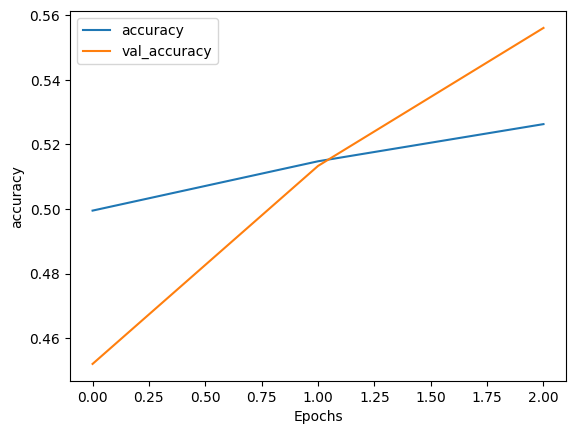

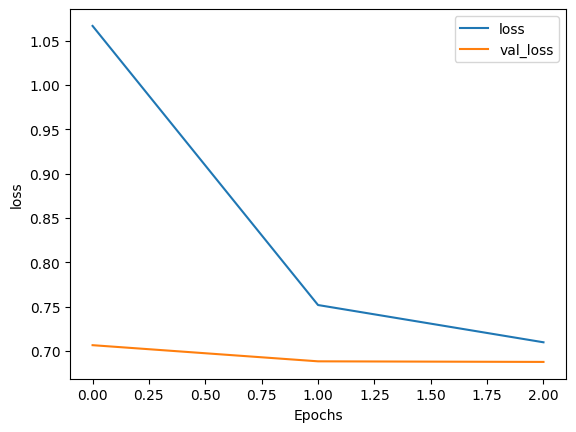

In [76]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [75]:
from sklearn.metrics import classification_report

# Generate predictions
test_predictions = model.predict(test_ids)
test_predictions = (test_predictions.flatten() > 0.5).astype(int)

# Print classification report
print(classification_report(test_labels.numpy(), test_predictions, target_names=["Not Sarcastic", "Sarcastic"]))


258/258 [==============================] - 12s 23ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.54      0.93      0.69      4321
    Sarcastic       0.65      0.14      0.24      3919

     accuracy                           0.56      8240
    macro avg       0.60      0.54      0.46      8240
 weighted avg       0.60      0.56      0.47      8240

